In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pyarrow as pa
import pyarrow.parquet as pq
import dask.dataframe as dd

In [ ]:
!pip install whoosh --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 5.5 MB/s eta 0:00:00


### Loading Books dataset json.gz

This script reads a compressed JSON file of book data, extracts only the necessary fields from each book, and filters out books with fewer than 50 ratings. The selected book entries are saved as list and converted to pandas DataFrame for further use.

In [ ]:
# This code reads and print the first line from the gzip compressed json
# file which has book data
import gzip

with gzip.open("/content/drive/MyDrive/Book Recommendation/goodreads_books.json.gz","r") as f:
  line= f.readline()
  print(line)

b'{"isbn": "0312853122", "text_reviews_count": "1", "series": [], "country_code": "US", "language_code": "", "popular_shelves": [{"count": "3", "name": "to-read"}, {"count": "1", "name": "p"}, {"count": "1", "name": "collection"}, {"count": "1", "name": "w-c-fields"}, {"count": "1", "name": "biography"}], "asin": "", "is_ebook": "false", "average_rating": "4.00", "kindle_asin": "", "similar_books": [], "description": "", "format": "Paperback", "link": "https://www.goodreads.com/book/show/5333265-w-c-fields", "authors": [{"author_id": "604031", "role": ""}], "publisher": "St. Martin\'s Press", "num_pages": "256", "publication_day": "1", "isbn13": "9780312853129", "publication_month": "9", "edition_information": "", "publication_year": "1984", "url": "https://www.goodreads.com/book/show/5333265-w-c-fields", "image_url": "https://images.gr-assets.com/books/1310220028m/5333265.jpg", "book_id": "5333265", "ratings_count": "3", "work_id": "5400751", "title": "W.C. Fields: A Life on Film", "t

In [ ]:
import json
json.loads(line)

{'isbn': '0312853122',
 'text_reviews_count': '1',
 'series': [],
 'country_code': 'US',
 'language_code': '',
 'popular_shelves': [{'count': '3', 'name': 'to-read'},
  {'count': '1', 'name': 'p'},
  {'count': '1', 'name': 'collection'},
  {'count': '1', 'name': 'w-c-fields'},
  {'count': '1', 'name': 'biography'}],
 'asin': '',
 'is_ebook': 'false',
 'average_rating': '4.00',
 'kindle_asin': '',
 'similar_books': [],
 'description': '',
 'format': 'Paperback',
 'link': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'authors': [{'author_id': '604031', 'role': ''}],
 'publisher': "St. Martin's Press",
 'num_pages': '256',
 'publication_day': '1',
 'isbn13': '9780312853129',
 'publication_month': '9',
 'edition_information': '',
 'publication_year': '1984',
 'url': 'https://www.goodreads.com/book/show/5333265-w-c-fields',
 'image_url': 'https://images.gr-assets.com/books/1310220028m/5333265.jpg',
 'book_id': '5333265',
 'ratings_count': '3',
 'work_id': '5400751',
 'title': '

In [ ]:
# each entry with selected fields is stored as dictionary
def parse_fields(line, fields):
  result={}
  data= json.loads(line)
  for field in fields:
    result[field]= data[field]
  return result


In [ ]:
# Only select the necessay features for training from the book data. only these
# will be populated from the dataset
fields = ["title_without_series", "average_rating", "ratings_count", "text_reviews_count", "popular_shelves", "authors", "similar_books", "num_pages", "format"]


In [ ]:
# reading only the necessary fields of the compressed book data line by line.
# Also books with ratings above 50 are kept for further processing.
books=[]
with gzip.open("/content/drive/MyDrive/Book Recommendation/goodreads_books.json.gz", "r") as f:
  line = f.readline()
  while True:
    if not line:
      break
    field = parse_fields(line, fields)
    try:
      rating_count = int(field["ratings_count"])
    except ValueError:
      continue
    if rating_count > 50:
      books.append(field)

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
#converting the list to dataframe for further processing
book_info = pd.DataFrame(books)


### Loading json file

In [ ]:
filepath = "data/goodreads_books.json"

In [ ]:
!wc -l "data/goodreads_books.json"

2360655 /content/drive/MyDrive/Book Recommendation/goodreads_books.json


There are 2.3M books

##Data Processing

### Filtering Metadata for English language books and Remove duplicates

In this section, to filter books written in English, a three-step verification process is used due to incomplete and unreliable metadata (~60% missing language codes). First, if the available language_code explicitly identifies the book as English (e.g., "en", "eng", "en-us", "en-gb"), it is accepted. Second, if the title text contains non-Latin scripts (such as Arabic, Chinese, Japanese, Cyrillic, or Korean), the book is rejected. Third, if neither check is conclusive, fastText language prediction is applied to the book title with a minimum probability threshold of 0.5 to ensure reliable classification, especially distinguishing English from similar Latin-script languages like French or German.



In [ ]:
# Install an older version of numpy (1.26.4) for fastText compatibility and
# restart the Colab runtime to apply the change
!pip install numpy==1.26.4 --quiet
import os
os.kill(os.getpid(), 9)  # Restart the Colab runtime to apply changes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.3 MB/s eta 0:00:00


In [ ]:
#install fasttext
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313505 sha256=6acdeba6d352f602fcb3cf8fd3b64ce8125818318d174465f009d9ac9be1055b
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [ ]:
# Download the pretrained fastText language identification model and load it.
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
import fasttext
fasttext_model = fasttext.load_model("/content/lid.176.bin")


--2025-04-06 12:57:08--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.239.50.120, 18.239.50.104, 18.239.50.18, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.239.50.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   206MB/s    in 0.6s    

2025-04-06 12:57:09 (206 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
fasttext_model.predict("Kafka on the shore")

(('__label__en',), array([0.54459292]))

In [ ]:
# Define a function to detect if a text contains non-Latin script characters
# (Arabic, Chinese, Japanese, Cyrillic, or Korean)
import re

def contains_non_latin_script(text):
    """
    Returns True if the text contains any non-Latin script characters
    (Arabic, Chinese, Japanese, Cyrillic, or Korean).
    """

    non_latin_pattern = re.compile(
        r'[\u0600-\u06FF'  # Arabic
        r'\u4E00-\u9FFF'   # Chinese (CJK Unified Ideographs)
        r'\u3040-\u30FF'   # Japanese (Hiragana + Katakana)
        r'\u0400-\u04FF'   # Cyrillic
        r'\uAC00-\uD7AF]'  # Korean Hangul
    )

    return bool(non_latin_pattern.search(text))


In [ ]:
# selecting only books in english language
def is_english(row, fasttext_model, treshold =0.5):
  lang = row.get("language_code", None)
  text = row.get("title_without_series","")

  if not text or text.strip()=="" or not isinstance(text, str):
    return False

  if contains_non_latin_script(text):
    return False

  label,prob = fasttext_model.predict(text)
  return label[0] == "__label__en" and prob[0] >= treshold
  #return label, prob

In [ ]:
print(f"\nShape before English filtering: {df.shape}")

# Step 1: Ensure description is string type for language detection
df["description_str"] = df["description"].astype(str).fillna('')

# Step 2: Apply the is_english function to create a boolean column
# Assumes 'is_english' function and 'fasttext_model' are available
df["is_english"] = df.apply(
    lambda row: is_english(row, fasttext_model, treshold=0.5), axis=1
)

# Step 3: Filter to keep only English books
books_df = df[df["is_english"]].copy()


# Step 4: Drop the temporary helper column
books_df = books_df.drop(columns=["is_english", "description_str"])

print(f"Shape after English filtering: {books_df.shape}")
print("\nSample after English filtering:")
print(books_df[['book_id', 'title_without_series', 'language_code', 'description']].head())



Shape before English filtering: (205853, 10)
Shape after English filtering: (162518, 10)

Sample after English filtering:
    book_id                               title_without_series language_code  \
0   2767052            The Hunger Games (The Hunger Games, #1)           eng   
1         3  Harry Potter and the Sorcerer's Stone (Harry P...           eng   
5  11870085                             The Fault in Our Stars           eng   
7      5107                             The Catcher in the Rye           eng   
8      1885                                Pride and Prejudice           eng   

                                         description  
0  Winning will make you famous.
Losing means cer...  
1  Harry Potter's life is miserable. His parents ...  
5  There is an alternate cover edition .
"I fell...  
7  The hero-narrator of The Catcher in the Ryeis ...  
8  "It is a truth universally acknowledged, that ...  


In [ ]:
# Assuming your DataFrame is 'books_df' with the structure you showed

# --- Phase 1: Normalization ---

# 1.1 Normalize title_without_series
def normalize_title(title):
    if pd.isna(title): # Handle NaN titles
        return ""
    title = str(title).lower() # Convert to string and lowercase

    # --- Crucial for "half of title" issue ---
    # Remove common subtitle/edition patterns from the end
    # This regex needs to be refined based on observed patterns
    # Examples:
    # - " : subtitle" -> ""
    # - " - subtitle" -> ""
    # - " a fable" -> ""
    # - " an old man" -> ""
    # - " the new complete edition" -> ""
    # - " volume 1" -> ""
    # - " book 1" -> ""
    subtitle_patterns = [
        r'\s*(audio|illustrated|complete|unabridged|abridged|paperback|hardcover|ebook|novel|series|edition)\s*.*$',
        r'\s*:\s*.*$',
        r'\s*[:;–—\-].*$',
        r'\s*book\s+\d+$',
        r'\s*the complete stories$',
        r'\s*illustrated edition$',
        r'\s*\([^)]*\)$', # Remove anything in parentheses at the end (e.g., (A Novel))
        r'\s*\[[^\]]*\]$', # Remove anything in square brackets at the end
    ]
    for pattern in subtitle_patterns:
        title = re.sub(pattern, '', title, flags=re.IGNORECASE).strip()

    # Remove common punctuation, replace with space
    title = re.sub(r'[^\w\s]', ' ', title)

    # Standardize whitespace: replace multiple spaces with single, then strip leading/trailing
    title = re.sub(r'\s+', ' ', title).strip()

    # Remove common trailing phrases that might be part of editions
    trailing_phrases = [
        r'\s*a novel$',
        r'\s*book$',
        r'\s*series$',
        r'\s*edition$'
    ]
    for pattern in trailing_phrases:
        title = re.sub(pattern, '', title, flags=re.IGNORECASE).strip()


    return title

# Apply normalization to the 'title_without_series' column
# Make sure to handle potential non-string values first
books_df['normalized_title_key'] = books_df['title_without_series'].astype(str).apply(normalize_title)

print(f"Original DataFrame shape: {books_df.shape}")

# Step 2.1: Sort by ratings_count to keep the most popular edition
# Ensure ratings_count is numeric
books_df["ratings_count"] = pd.to_numeric(books_df["ratings_count"], errors='coerce').fillna(0)
books_df_sorted = books_df.sort_values(by="ratings_count", ascending=False).reset_index(drop=True)

# Step 2.2: Drop duplicates based on the normalized keys
books_df_deduplicated = books_df_sorted.drop_duplicates(
    subset=['normalized_title_key'],
    keep='first' # Keep the first (most popular due to sorting) occurrence
)

# Optional: Drop the temporary normalization columns if not needed further
books_df= books_df_deduplicated.drop(columns=['normalized_title_key'])

print(f"Shape after deduplication: {books_df.shape}")
print("\nSample of deduplicated DataFrame:")
# Display first few rows with relevant columns to verify
print(books_df[['book_id', 'title_without_series', 'authors', 'ratings_count']].head())

Original DataFrame shape: (162518, 12)
Shape after deduplication: (161618, 10)

Sample of deduplicated DataFrame:
    book_id                               title_without_series  \
0   2767052            The Hunger Games (The Hunger Games, #1)   
1         3  Harry Potter and the Sorcerer's Stone (Harry P...   
2  11870085                             The Fault in Our Stars   
3      5107                             The Catcher in the Rye   
4      1885                                Pride and Prejudice   

                                             authors  ratings_count  
0                                           [153394]        4899965  
1                                    [1077326, 2927]        4765497  
2                                          [1406384]        2429317  
3                                           [819789]        2086945  
4  [1265, 3500, 16378912, 14532, 1244, 13771732, ...        2078406  


In [ ]:
# This script preprocesses a large dataset of book metadata from a JSON file.
# It reads the data in chunks, selects relevant fields, simplifies nested structures,
# filters for books identified as being in English, and saves the cleaned data
# to an efficient Parquet file for subsequent use (e.g., in a recommendation system).


# Define the necessary fields from the original dataset
fields = ["title_without_series", "authors", "average_rating", "ratings_count", "book_id",
          "popular_shelves", "similar_books",  "language_code", "description"]

# Read in chunks (adjust chunk size as needed)
chunk_size = 100000  # Adjust based on memory availability

# Define the output Parquet file path
output_file = "data/filtered_books.parquet"

# Initialize variables
writer = None
counter = 0
total_rows = 0

# If an old output file exists, remove it before starting
if os.path.exists(output_file):
  os.remove(output_file)



# Define a function to simplify fields by flattening nested lists
def simplify_fields(chunk):
  """
    Simplify the 'popular_shelves' and 'authors' fields:
    - 'popular_shelves': keep only shelf names.
    - 'authors': keep only author IDs.
    """

  #flatten author and popular shelves
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
      lambda shelves: [shelf["name"] for shelf in shelves] if isinstance(shelves, list) else [])
  chunk["authors"] = chunk["authors"].apply(
      lambda authors: [author["author_id"] for author in authors] if isinstance(authors, list) else [])

  return chunk



# Read the large JSON file in chunks
for i, chunk in enumerate(pd.read_json(filepath, lines=True, chunksize=chunk_size)):

    print(f"Processing chunk {counter}: {total_rows} rows")
    chunk = chunk[fields]  # Select only required columns

    #Simplify popular shelves field to remove unnecessary data
    chunk = simplify_fields(chunk)

    # Apply multi-step English language filtering
    # 1. Use 'language_code' if available
    # 2. Check for non-Latin scripts
    # 3. Use fastText prediction with 0.5 probability threshold
    chunk["is_english"] = chunk.apply(
        lambda row: is_english(row,fasttext_model, treshold = 0.5), axis =1
    )

    # Keep only English books
    chunk = chunk[chunk["is_english"]].copy()

    # Drop the temporary 'is_english' helper column
    chunk = chunk.drop(columns=["is_english"])

    # Convert DataFrame to Arrow Table
    table = pa.Table.from_pandas(chunk)

    # Initialize the Parquet writer if not already done
    if writer is None:
        writer = pq.ParquetWriter(output_file, table.schema, compression="snappy")

    # Write the table to the Parquet file
    writer.write_table(table)

    # Update counters
    total_rows+=len(chunk)
    counter += 1

# Don't forget to close the writer
if writer:
    writer.close()


Processing chunk 0: 0 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 1: 68440 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 2: 136936 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 3: 205120 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 4: 272987 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 5: 341195 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 6: 409278 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 7: 477230 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 8: 545231 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 9: 613202 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 10: 681230 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 11: 749320 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 12: 817263 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 13: 885765 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 14: 954276 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 15: 1022601 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 16: 1091006 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 17: 1159158 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 18: 1227177 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 19: 1295056 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 20: 1363359 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 21: 1431134 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 22: 1499280 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Processing chunk 23: 1567185 rows


<ipython-input-7-e9b7b91fe6d3>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["popular_shelves"] = chunk["popular_shelves"].apply(
<ipython-input-7-e9b7b91fe6d3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk["authors"] = chunk["authors"].apply(
<ipython-input-7-e9b7b91fe6d3>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

'\n# Merge all filtered chunks\ndf = pd.read_parquet(output_file)\n\n# Display the first few rows\ndisplay(df.head())\n'

### Type casting

In [ ]:

df = dd.read_parquet("/content/drive/MyDrive/Book item-item/filtered_books.parquet")
df_pandas = df.compute()

Average rating and ratings count should be of int type but it is string

In [ ]:
# Clean and ensure correct numeric types for 'ratings_count' and 'average_rating' columns,
# handling invalid entries appropriately

# Convert 'ratings_count' to numeric; invalid parsing results will be set to NaN
df_pandas["ratings_count"] = pd.to_numeric(df_pandas['ratings_count'], errors="coerce")

# Drop rows where 'ratings_count' is missing (NaN) after conversion
df_pandas = df_pandas.dropna(subset=["ratings_count"])


# Convert cleaned 'ratings_count' to integer type
df_pandas["ratings_count"] = df_pandas["ratings_count"].astype(int)


# Convert 'average_rating' to numeric; invalid entries will be set to NaN
df_pandas["average_rating"] = pd.to_numeric(df_pandas["average_rating"], errors='coerce')

<ipython-input-5-ae889c11fe39>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pandas["ratings_count"] = df_pandas["ratings_count"].astype(int)


In [ ]:
df_pandas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1608029 entries, 1 to 2360654
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   title_without_series  1608029 non-null  string 
 1   authors               1608029 non-null  object 
 2   average_rating        1608029 non-null  Float64
 3   ratings_count         1608029 non-null  int64  
 4   book_id               1608029 non-null  int64  
 5   popular_shelves       1608029 non-null  object 
 6   similar_books         1608029 non-null  object 
 7   language_code         1608029 non-null  string 
 8   description           1608029 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 1.3+ GB


In [ ]:
df_pandas.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description
1,Good Harbor,[626222],3.23,10,1333909,"[to-read, fiction, currently-reading, contempo...","[8709549, 17074050, 28937, 158816, 228563, 112...",,"Anita Diamant's international bestseller ""The ..."
2,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",[10333],4.03,140,7327624,"[to-read, fantasy, fiction, owned, hardcover, ...","[19997, 828466, 1569323, 425389, 1176674, 2627...",eng,Omnibus book club edition containing the Ladie...
3,Best Friends Forever,[9212],3.49,51184,6066819,"[to-read, chick-lit, currently-reading, fictio...","[6604176, 6054190, 2285777, 82641, 7569453, 70...",eng,Addie Downs and Valerie Adler were eight when ...
4,Runic Astrology: Starcraft and Timekeeping in ...,[149918],3.4,15,287140,"[to-read, runes, owned, nonfiction, kill-it-wi...",[],,
5,The Aeneid for Boys and Girls,[3041852],4.13,46,287141,"[to-read, currently-reading, history, classics...",[],,"Relates in vigorous prose the tale of Aeneas, ..."


### Finding rating cutoff

In [ ]:
# Display the count of each unique value in the 'average_rating' column
df_pandas["average_rating"].value_counts()

,count
average_rating,
4.0,68648
5.0,43568
3.0,27004
4.5,22298
3.5,20817
...,...
1.28,1
1.51,1
1.99,1


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def histogram_plot(data, column_name):
  plt.figure(figsize=(10,6))
  sns.histplot(data[column_name], bins=100, binrange=(0, 1000))
  plt.xlim(0, 1000)
  plt.title(f"Histogram of {column_name}")
  plt.xlabel(column_name)
  plt.ylabel("Frequency")
  plt.show()


In [ ]:
df_pandas["ratings_count"].value_counts()

,count
ratings_count,
1,79258
2,63969
3,52964
4,45205
5,39367
...,...
1962813,1
2023937,1
2028299,1


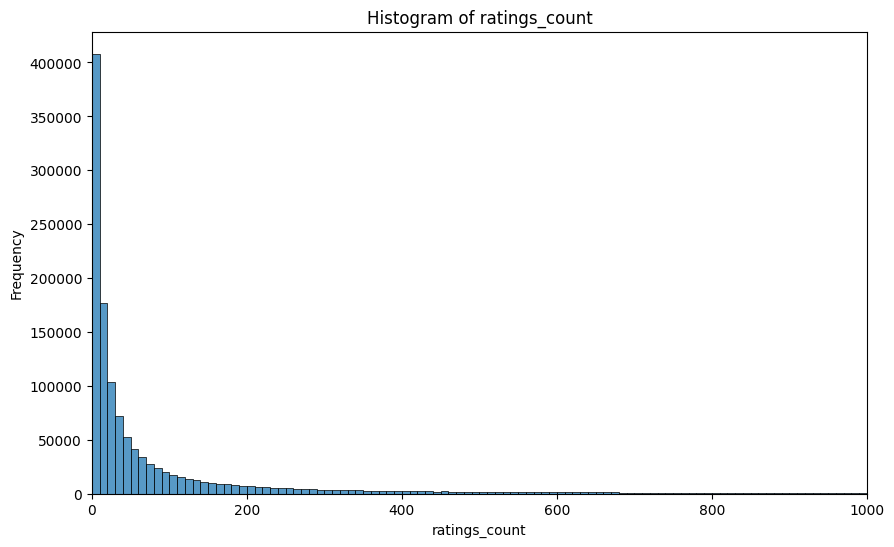

In [ ]:
histogram_plot(df_pandas, "ratings_count")

A histogram of ratings_count reveals a highly skewed distribution, where most books have received fewer than 50-60 ratings. The data is heavily concentrated in the lower end, with a long tail representing a small number of highly rated books.

In [ ]:
# Calculate and display key quantiles
# (25th, 50th, 75th, 90th, and 95th percentiles) for the 'ratings_count' column

df_pandas["ratings_count"].quantile([0.25, 0.5, 0.75, 0.9, 0.95])


,ratings_count
0.25,7.0
0.50,25.0
0.75,104.0
0.90,444.0
0.95,1173.0


In [ ]:
# Filter the dataset to keep only books with more than 100 ratings and an
# average rating greater than 3.0

df_pandas = df_pandas[((df_pandas["ratings_count"] > 100) & (df_pandas["average_rating"]>3.7))]

Reason:
 - Books with very few ratings may have unreliable feedback and are difficult for collaborative filtering models (cold start problem)
 - Books with low average ratings are generally less appealing to recommend
 - Reducing the dataset size improves computational efficiency: smaller matrices, faster training, and quicker similarity calculations
 This filtering ensures higher-quality data and makes the recommendation system more scalable and practical.

In [ ]:
df_pandas.to_parquet("/content/drive/MyDrive/Book item-item/filtered_books_data_wrangled.parquet", index=False)

## Lammetized Data


In [ ]:
import pandas as pd

In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/Book item-item/filtered_books_data_wrangled.parquet")

In [ ]:
df.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description
0,"The Hunger Games (The Hunger Games, #1)",[153394],4.34,4899965,2767052,"[favorites, currently-reading, to-read, young-...","[1902241, 146499, 954674, 9917938, 10165727, 7...",eng,Winning will make you famous. Losing means cer...
1,Harry Potter and the Sorcerer's Stone (Harry P...,"[1077326, 2927]",4.45,4765497,3,"[to-read, favorites, fantasy, young-adult, fic...","[13830, 127586, 121822, 37586, 6164358, 807968...",eng,Harry Potter's life is miserable. His parents ...
2,"Twilight (Twilight, #1)",[941441],3.57,3941381,41865,"[to-read, young-adult, fantasy, favorites, vam...","[1326258, 140077, 35729, 30123413, 11260526, 9...",en-US,About three things I was absolutely positive. ...
3,To Kill a Mockingbird,[1825],4.26,3255518,2657,"[to-read, favorites, classics, classic, histor...","[1934, 2156, 15638, 53835, 77142, 5114, 116020...",eng,The unforgettable novel of a childhood in a sl...
4,The Great Gatsby,[3190],3.89,2758812,4671,"[to-read, classics, favorites, fiction, classi...","[48203, 337113, 176972, 188087, 10956, 12722, ...",eng,"THE GREAT GATSBY, F. Scott Fitzgerald's third ..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   title_without_series  326230 non-null  string 
 1   authors               326230 non-null  object 
 2   average_rating        326230 non-null  Float64
 3   ratings_count         326230 non-null  int64  
 4   book_id               326230 non-null  int64  
 5   popular_shelves       326230 non-null  object 
 6   similar_books         326230 non-null  object 
 7   language_code         326230 non-null  string 
 8   description           326230 non-null  string 
dtypes: Float64(1), int64(2), object(3), string(3)
memory usage: 22.7+ MB


In [ ]:
df.loc[7]["description"]

"The hero-narrator of The Catcher in the Ryeis an ancient child of sixteen, a native New Yorker named Holden Caulfield. Through circumstances that tend to preclude adult, secondhand description, he leaves his prep school in Pennsylvania and goes underground in New York City for three days. The boy himself is at once too simple and too complex for us to make any final comment about him or his story. Perhaps the safest thing we can say about Holden is that he was born in the world not just strongly attracted to beauty but, almost, hopelessly impaled on it. There are many voices in this novel: children's voices, adult voices, underground voices-but Holden's voice is the most eloquent of all. Transcending his own vernacular, yet remaining marvelously faithful to it, he issues a perfectly articulated cry of mixed pain and pleasure. However, like most lovers and clowns and poets of the higher orders, he keeps most of the pain to, and for, himself. The pleasure he gives away, or sets aside, w

###Lammetized Data




In [ ]:
import re, string, nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import spacy

try:
  nlp = spacy.load("en_core_web_sm")
except OSError:
  print("SpaCy model 'en_core_web_sm' not found. Please run 'python -m spacy download en_core_web_sm'")
  nlp = None

STOPWORDS = set(stopwords.words("english"))

print("\nApplying tokenizer using nlp.pipe()...")
if nlp: # Only proceed if model loaded
    # nlp.pipe requires an iterable of strings.
    # Handle potential None/NaN in the original column by replacing with empty strings.
    descriptions_for_pipe = df['description'].fillna('').astype(str).tolist()

    # Process texts in batches using nlp.pipe
    # `disable=['parser', 'ner']` disables components we don't need for just lemmatization
    # which can speed things up if your model has those components.
    processed_docs = nlp.pipe(descriptions_for_pipe, disable=['parser', 'ner'])

    # Iterate through the processed docs and extract/filter lemmas
    lemmatized_tokens_pipe = []
    for doc in processed_docs:
        # Reapply the filtering logic to each processed doc
        tokens = [
             token.lemma_.lower()
             for token in doc
             if token.lemma_.lower() not in STOPWORDS
             and not token.is_punct
             and not token.is_space
             # Optional: Add check for short tokens
        ]
        lemmatized_tokens_pipe.append(tokens)

    # Assign the resulting list to a new column
    df['lemmatized_description_pipe'] = lemmatized_tokens_pipe

    print("\nDataFrame after nlp.pipe():")
    print(df[['book_id', 'description', 'lemmatized_description_pipe']])

else:
    print("Skipping nlp.pipe() because spaCy model failed to load.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Applying tokenizer using nlp.pipe()...

DataFrame after nlp.pipe():
         book_id                                        description  \
0        2767052  Winning will make you famous.
Losing means cer...   
1              3  Harry Potter's life is miserable. His parents ...   
2          41865  About three things I was absolutely positive.
...   
3           2657  The unforgettable novel of a childhood in a sl...   
4           4671  THE GREAT GATSBY, F. Scott Fitzgerald's third ...   
...          ...                                                ...   
326225  18363056  With evil lurking on every corner, can two ver...   
326226   1137199  A delightful collection of magical folk tales
...   
326227  34827846  "My one fear is now my reality."
He didn't off...   
326228  11114177  Why did the flushing toilet take two centuries...   
326229  12988686  Nate Whitney had always had a connection to na...   

                              lemmatized_description_pipe  
0       [win, make

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         326230 non-null  string 
 1   authors                      326230 non-null  object 
 2   average_rating               326230 non-null  Float64
 3   ratings_count                326230 non-null  int64  
 4   book_id                      326230 non-null  int64  
 5   popular_shelves              326230 non-null  object 
 6   similar_books                326230 non-null  object 
 7   language_code                326230 non-null  string 
 8   description                  326230 non-null  string 
 9   lemmatized_description_pipe  326230 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 25.2+ MB


In [ ]:
parquet_file_path = "/content/drive/MyDrive/Book item-item/books_lemmatized_description.parquet"
try:
  df.to_parquet(parquet_file_path, index=False)
  print(f"DataFrame saved")
except Exception as e:
  print(f"Error saving DataFrame : {e}")

Error saving DataFrame : name 'df' is not defined


##Model Training

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326230 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         326230 non-null  string 
 1   authors                      326230 non-null  object 
 2   average_rating               326230 non-null  Float64
 3   ratings_count                326230 non-null  int64  
 4   book_id                      326230 non-null  int64  
 5   popular_shelves              326230 non-null  object 
 6   similar_books                326230 non-null  object 
 7   language_code                326230 non-null  string 
 8   description                  326230 non-null  string 
 9   lemmatized_description_pipe  326230 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 25.2+ MB


In [ ]:
books_df.head()

,title_without_series,authors,average_rating,ratings_count,book_id,popular_shelves,similar_books,language_code,description,lemmatized_description_pipe
0,"The Hunger Games (The Hunger Games, #1)",[153394],4.34,4899965,2767052,"[favorites, currently-reading, to-read, young-...","[1902241, 146499, 954674, 9917938, 10165727, 7...",eng,Winning will make you famous. Losing means cer...,"[win, make, famous, losing, mean, certain, dea..."
1,Harry Potter and the Sorcerer's Stone (Harry P...,"[1077326, 2927]",4.45,4765497,3,"[to-read, favorites, fantasy, young-adult, fic...","[13830, 127586, 121822, 37586, 6164358, 807968...",eng,Harry Potter's life is miserable. His parents ...,"[harry, potter, 's, life, miserable, parent, d..."
2,"Twilight (Twilight, #1)",[941441],3.57,3941381,41865,"[to-read, young-adult, fantasy, favorites, vam...","[1326258, 140077, 35729, 30123413, 11260526, 9...",en-US,About three things I was absolutely positive. ...,"[three, thing, absolutely, positive, first, ed..."
3,To Kill a Mockingbird,[1825],4.26,3255518,2657,"[to-read, favorites, classics, classic, histor...","[1934, 2156, 15638, 53835, 77142, 5114, 116020...",eng,The unforgettable novel of a childhood in a sl...,"[unforgettable, novel, childhood, sleepy, sout..."
4,The Great Gatsby,[3190],3.89,2758812,4671,"[to-read, classics, favorites, fiction, classi...","[48203, 337113, 176972, 188087, 10956, 12722, ...",eng,"THE GREAT GATSBY, F. Scott Fitzgerald's third ...","[great, gatsby, f., scott, fitzgerald, 's, thi..."


In [ ]:
updated_books_df = books_df[(books_df['average_rating']>=3.7) & (books_df['ratings_count']>100)]

In [ ]:
updated_books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137572 entries, 0 to 326229
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         137572 non-null  string 
 1   authors                      137572 non-null  object 
 2   average_rating               137572 non-null  Float64
 3   ratings_count                137572 non-null  int64  
 4   book_id                      137572 non-null  int64  
 5   popular_shelves              137572 non-null  object 
 6   similar_books                137572 non-null  object 
 7   language_code                137572 non-null  string 
 8   description                  137572 non-null  string 
 9   lemmatized_description_pipe  137572 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 11.7+ MB


In [ ]:
from IPython.display import Javascript

# This JS code will click the reconnect button every 60 000 ms (1 min)
js = """
function ClickConnect(){
  console.log("⏳ Keep-alive ping");
  document.querySelector("colab-connect-button")
          .shadowRoot.querySelector("#connect").click();
}
setInterval(ClickConnect, 60000);
"""

display(Javascript(js))


<IPython.core.display.Javascript object>

##Building Ranking system using Whoosh on Description

In [ ]:
token_lists = (
    books_df["lemmatized_description_pipe"]
      .apply(lambda arr: arr.tolist())      # ndarray → list[str]
      .tolist()                             # Series → list of docs
)
book_ids = books_df["book_id"].tolist()

In [ ]:
data        = [(int(b), toks)
               for b, toks in zip(book_ids, token_lists) if toks]
N_DOCS      = len(data)   # total number of books to process
N_DOCS

122224

In [ ]:
# 1. How long is each list?
print("len(book_ids)     =", len(book_ids))
print("len(token_lists)  =", len(token_lists))

# 2. How many token_lists entries are empty or falsey?
empty_count = sum(1 for toks in token_lists if not toks)
print("empty token_lists =", empty_count)

# 3. How many pairs does zip produce?
print("len(list(zip(book_ids, token_lists))) =",
      len(list(zip(book_ids, token_lists))))


len(book_ids)     = 137572
len(token_lists)  = 137572
empty token_lists = 15348
len(list(zip(book_ids, token_lists))) = 137572


In [ ]:
# -------------------------
# 0) Configuration
# -------------------------
# Load and filter your data into a list of (book_id, tokens) pairs
token_lists = books_df["lemmatized_description_pipe"] \
                   .apply(lambda arr: arr.tolist()) \
                   .tolist()
book_ids    = books_df["book_id"].tolist()
# Keep only entries with non-empty token lists
data        = [(int(b), toks)
               for b, toks in zip(book_ids, token_lists) if toks]
N_DOCS      = len(data)   # total number of books to process

# Decide how many worker processes to launch
NUM_WORKERS    = mp.cpu_count()
# How often each worker will print a “heartbeat” status
PROGRESS_EVERY = 2000
# Directory for the on-disk Whoosh index
IDX_DIR        = "whoosh_idx_135k"
# Number of neighbors to fetch per query
TOP_K          = 100

print(f"Using {N_DOCS} books; launching {NUM_WORKERS} workers")

# -------------------------
# 1) Build the Whoosh index
# -------------------------
# Define the schema: an ID field for book_id and a TEXT field for description
my_lemmatized_analyzer = RegexTokenizer() | LowercaseFilter()
schema = Schema(
    book_id = ID(stored=True, unique=True),
    content = TEXT(stored=False, analyzer=my_lemmatized_analyzer)
)

# Create (or reuse) the index directory
os.makedirs(IDX_DIR, exist_ok=True)
ix = index.create_in(IDX_DIR, schema)

# Open a multi-process writer (leverages NUM_WORKERS threads)
writer = ix.writer(procs=NUM_WORKERS, limitmb=2048)

start_time = time.time()
for i, (bid, toks) in enumerate(data, start=1):
    # Add each document to the index
    # .join is done because the whoosh tokenizer expect the data as 1 big string.
    # this data will further broken and analysed in the selected analyzer
    writer.add_document(book_id=str(bid), content=" ".join(toks))
    # Periodically report progress and ETA
    if i % PROGRESS_EVERY == 0 or i == N_DOCS:
        elapsed = time.time() - start_time
        eta     = elapsed * (N_DOCS - i) / i
        print(f"Indexed {i}/{N_DOCS} docs — "
              f"{elapsed:.0f}s elapsed, ETA {eta/60:.1f}m",
              flush=True)
# Commit and close the writer
writer.commit()
print(f"Index build completed in {(time.time() - start_time)/60:.1f} minutes")

# -------------------------
# 2) Prepare data chunks
# -------------------------
# Split the list of documents into roughly equal chunks for each worker
chunk_size = math.ceil(N_DOCS / NUM_WORKERS)
chunks     = [data[i : i + chunk_size]
              for i in range(0, N_DOCS, chunk_size)]

# -------------------------
# 3) Define the worker
# -------------------------
def worker(chunk):
    """
    Each worker process:
    - Opens the shared Whoosh index
    - Initializes a BM25 searcher
    - Iterates over its assigned slice of (book_id, tokens)
    - Runs a BM25 query for each book’s tokens
    - Collects top-K neighbours (excluding itself) into a dict
    - Prints a heartbeat every PROGRESS_EVERY queries
    """
    ix       = index.open_dir(IDX_DIR)
    searcher = ix.searcher(weighting=scoring.BM25F(B=0.75, K1=1.5))
    qp       = QueryParser("content", schema=ix.schema)
    local    = {}
    start_w  = time.time()
    proc     = mp.current_process().name

    for idx, (bid, toks) in enumerate(chunk, start=1):
        # Build and execute the BM25 query
        q    = qp.parse(" ".join(toks))
        hits = searcher.search(q, limit=TOP_K)
        # Store neighbour list: (neighbour_id, score)
        local[bid] = [
            (int(h["book_id"]), h.score)
            for h in hits
            if int(h["book_id"]) != bid
        ]
        # Heartbeat: report progress within this worker’s chunk
        if idx % PROGRESS_EVERY == 0 or idx == len(chunk):
            elapsed = time.time() - start_w
            rate    = idx / elapsed
            eta     = (len(chunk) - idx) / rate
            print(f"{proc}: processed {idx}/{len(chunk)} — "
                  f"{elapsed:.0f}s elapsed, ETA {eta/60:.1f}m",
                  flush=True)
    return local

# -------------------------
# 4) Run parallel querying
# -------------------------
print("Starting parallel BM25 queries…")
t0 = time.time()
bm25_table = {}
# Use a process pool to run workers concurrently
with mp.Pool(NUM_WORKERS) as pool:
    # imap_unordered yields each worker’s result dict as it finishes
    for part in tqdm(pool.imap_unordered(worker, chunks), total=len(chunks)):
        # Merge partial results into the global table
        bm25_table.update(part)

total_time = time.time() - t0
print(f"Completed all {N_DOCS} queries in {total_time/60:.1f} minutes")

# -------------------------
# 5) Save the neighbour table
# -------------------------
out_path = "/content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100_custom_analyzer.pkl"
with open(out_path, "wb") as f:
    pickle.dump(bm25_table, f)
size_mb = os.path.getsize(out_path) / 2**20
print(f"Saved {len(bm25_table)} neighbour lists to {out_path} ({size_mb:.1f} MB)")


Using 122224 books; launching 8 workers
Indexed 2000/122224 docs — 0s elapsed, ETA 0.3m
Indexed 4000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 6000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 8000/122224 docs — 0s elapsed, ETA 0.1m
Indexed 10000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 12000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 14000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 16000/122224 docs — 1s elapsed, ETA 0.1m
Indexed 18000/122224 docs — 2s elapsed, ETA 0.2m
Indexed 20000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 22000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 24000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 26000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 28000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 30000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 32000/122224 docs — 2s elapsed, ETA 0.1m
Indexed 34000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 36000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 38000/122224 docs — 3s elapsed, ETA 0.1m
Indexed 40000/122224 docs — 3s el

  0%|          | 0/8 [00:00<?, ?it/s]

ForkPoolWorker-16: processed 2000/15278 — 1236s elapsed, ETA 136.7m
ForkPoolWorker-15: processed 2000/15278 — 1238s elapsed, ETA 137.0m
ForkPoolWorker-13: processed 2000/15278 — 1249s elapsed, ETA 138.2m
ForkPoolWorker-14: processed 2000/15278 — 1255s elapsed, ETA 138.9m
ForkPoolWorker-10: processed 2000/15278 — 1287s elapsed, ETA 142.4m
ForkPoolWorker-11: processed 2000/15278 — 1290s elapsed, ETA 142.7m
ForkPoolWorker-12: processed 2000/15278 — 1307s elapsed, ETA 144.6m
ForkPoolWorker-9: processed 2000/15278 — 1323s elapsed, ETA 146.4m
ForkPoolWorker-15: processed 4000/15278 — 2492s elapsed, ETA 117.1m
ForkPoolWorker-16: processed 4000/15278 — 2500s elapsed, ETA 117.5m
ForkPoolWorker-13: processed 4000/15278 — 2514s elapsed, ETA 118.2m
ForkPoolWorker-14: processed 4000/15278 — 2543s elapsed, ETA 119.5m
ForkPoolWorker-10: processed 4000/15278 — 2572s elapsed, ETA 120.9m
ForkPoolWorker-11: processed 4000/15278 — 2599s elapsed, ETA 122.2m
ForkPoolWorker-12: processed 4000/15278 — 2638s e

 12%|█▎        | 1/8 [2:42:22<18:56:36, 9742.43s/it]

ForkPoolWorker-15: processed 15278/15278 — 9790s elapsed, ETA 0.0m


 25%|██▌       | 2/8 [2:43:11<6:44:01, 4040.20s/it] 

ForkPoolWorker-14: processed 15278/15278 — 9827s elapsed, ETA 0.0m


 38%|███▊      | 3/8 [2:43:48<3:04:21, 2212.28s/it]

ForkPoolWorker-13: processed 15278/15278 — 9899s elapsed, ETA 0.0m


 50%|█████     | 4/8 [2:44:59<1:31:08, 1367.20s/it]

ForkPoolWorker-10: processed 15278/15278 — 9951s elapsed, ETA 0.0m


 62%|██████▎   | 5/8 [2:45:51<44:38, 892.92s/it]   

ForkPoolWorker-12: processed 15278/15278 — 10015s elapsed, ETA 0.0m


 75%|███████▌  | 6/8 [2:46:55<20:22, 611.04s/it]

ForkPoolWorker-11: processed 15278/15278 — 10024s elapsed, ETA 0.0m


 88%|████████▊ | 7/8 [2:47:04<06:54, 414.03s/it]

ForkPoolWorker-9: processed 15278/15278 — 10052s elapsed, ETA 0.0m


100%|██████████| 8/8 [2:47:32<00:00, 1256.56s/it]

Completed all 122224 queries in 167.5 minutes
Saved 122224 neighbour lists to /content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100_custom_analyzer.pkl (1.3 MB)


The problem here is, even though all books had description, using BM25 model on building recommendations on Description feature resulted in no recommendations for many books. this might be because, there are many dissimilar books or BM25 failed to see any similarity in it.
this probably happened because, i use keyword analyser in Whoosh retrival system. Keyword analyser treets the whole discription as 1 atring and tries to find similarity. however this is not suitable for description which has a lot of strings, Keyword analyse is best for data like titles, genres ets. so Building custom analyser did not improve the results much. out of 122224 data, only 13138 had recommendations which is just slightly higher than 12924 recommendations from keyword analyzer.
Tried just using description field of data and let the whoosh analyser do the lemmatizing and lowercasing an other work but this take lot of execution time. approx 12 hours. so aborted and tring sentense transformer to get semantic meaning


In [ ]:

file_path = "/content/drive/MyDrive/Book item-item/135k_books_lemmatized_description.parquet"
try:
  books_df = pd.read_parquet(file_path)
  print("Dataframe loaded")
except Exception as e:
  print(f"error loadinf {e}")

Dataframe loaded


In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137572 entries, 0 to 137571
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         137572 non-null  string 
 1   authors                      137572 non-null  object 
 2   average_rating               137572 non-null  Float64
 3   ratings_count                137572 non-null  int64  
 4   book_id                      137572 non-null  int64  
 5   popular_shelves              137572 non-null  object 
 6   similar_books                137572 non-null  object 
 7   language_code                137572 non-null  string 
 8   description                  137572 non-null  string 
 9   lemmatized_description_pipe  137572 non-null  object 
dtypes: Float64(1), int64(2), object(4), string(3)
memory usage: 10.6+ MB


In [ ]:
books_df["popular_shelves"].iloc[1]

array(['to-read', 'favorites', 'fantasy', 'young-adult', 'fiction',
       'harry-potter', 'books-i-own', 'owned', 'ya', 'series',
       'favourites', 'magic', 'childrens', 're-read', 'children',
       'adventure', 'owned-books', 'classics', 'children-s', 'childhood',
       'middle-grade', 'reread', 'all-time-favorites', 'j-k-rowling',
       'sci-fi-fantasy', 'children-s-books', 'my-books', 'kids',
       'audiobook', 'favorite-books', 'default', 'audiobooks', 'novels',
       '5-stars', 'i-own', 'favorite', 'read-in-2016', 'fantasy-sci-fi',
       'paranormal', 'read-more-than-once', 're-reads', 'my-library',
       'read-in-2015', 'books', 'english', 'ya-fantasy', 'read-in-2017',
       'childrens-books', 'british', 'urban-fantasy', 'mystery', 'teen',
       'audio', 'favorite-series', 'library', 'supernatural',
       'my-favorites', 'read-in-2014', 'novel', 'faves', 'jk-rowling',
       'own-it', 'ya-fiction', 'harry-potter-series', 'kindle',
       'juvenile', 'childhood-favor

In [ ]:
import pickle
with open("/content/drive/MyDrive/Book item-item/bm25_neighbors_135k_top100.pkl", "rb") as f:
  bm25_table = pickle.load(f)

In [ ]:
empty_count = sum(1 for list in bm25_table.values() if not list)

In [ ]:
type(bm25_table)

dict

In [ ]:
bm25_table


{17130546: [],
 18756844: [],
 27571369: [],
 58963: [(8534091, 180.32747726066046)],
 21453562: [],
 180090: [],
 28782949: [],
 839075: [],
 33197725: [],
 22529224: [],
 24973792: [],
 15854661: [(15854588, 512.012408913791),
  (15854584, 512.012408913791),
  (15854579, 512.012408913791),
  (15854613, 512.012408913791),
  (15854684, 512.012408913791),
  (15854640, 512.012408913791),
  (15854641, 512.012408913791),
  (15854642, 512.012408913791),
  (15854842, 512.012408913791),
  (15854587, 512.012408913791),
  (15854611, 512.012408913791),
  (15854627, 512.012408913791),
  (15854726, 512.012408913791),
  (15854583, 512.012408913791),
  (15854615, 512.012408913791),
  (15854610, 512.012408913791),
  (15854617, 512.012408913791),
  (15854625, 512.012408913791),
  (15854631, 512.012408913791),
  (15854885, 512.012408913791),
  (15854847, 512.012408913791),
  (15854619, 512.012408913791),
  (15854624, 512.012408913791),
  (15854644, 512.012408913791),
  (15854851, 512.012408913791),
  (

In [ ]:
print(empty_count)

109300


In [ ]:
len(bm25_table) - empty_count

12924

## Semantic Search using Sentence Transformer & FAISS on Description

This section focuses on building book recommendations based on description content, leveraging state-of-the-art Sentence Transformers and FAISS. This approach offers a significant advantage over traditional keyword-based methods like BM25 (which is implemented with Whoosh) because it
allows us to capture **semantic similarity**. While BM25 excels at finding documents that share specific words and their frequencies, Sentence Transformers can identify books that are similar in *meaning* and *theme*, even if they use different vocabulary. This provides a richer and more nuanced understanding of book relationships for recommendation purposes.

In [ ]:
try:
  books_df = pd.read_parquet("data/books_dataframe.parquet")
except Exception as e:
  print(f"Error loading Dataframe: {e}")
except FileNotFoundError as e:
  print(f"Error loading Dataframe: {e}")

In [ ]:
!pip install sentence_transformers faiss-cpu tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
from sentence_transformers import  SentenceTransformer
import faiss

In [ ]:
# books_df["book_id"] is a panda series. this will have index so to extract the values,
# .values is called. converting it to numpy array since NumPy array is more compact in
# memory and has faster indexing than a Python list. and also makes sure all the
# values will be int
book_ids = books_df["book_id"].values.astype(np.int64)

In [ ]:
description = books_df["description"].tolist()

In [ ]:
# filter to only contain fields with description
data = [(bid, desc) for bid, desc in zip(book_ids, description) if desc]

In [ ]:
len(data)

131428

In [ ]:
books_df.shape

(148895, 11)

In [ ]:
filtered_ids = [bid for bid, _ in data]
filtered_desc = [desc for _, desc in data]

In [ ]:
filtered_ids = np.array(filtered_ids, np.int64)

In [ ]:
N = len(filtered_desc)

In [ ]:
# Load the model (downloads weights if necessary)
model = SentenceTransformer("intfloat/e5-large")

# Compute embeddings in batches for memory efficiency
batch_size = 256
embeddings = np.zeros((N, 1024), dtype="float32")

for start in tqdm(range(0, N, batch_size), desc="Encoding descriptions"):
    end = start + batch_size
    batch = filtered_desc[start:end]
    embs = model.encode(batch, convert_to_numpy=True, normalize_embeddings=True)
    embeddings[start:end] = embs


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

Encoding descriptions: 100%|██████████| 514/514 [20:54<00:00,  2.44s/it]


In [ ]:
# Saving the embeddings to a file for future reference
np.save("data/book_embeddings_description_v2.npy", embeddings)

###Implementing FAISS

In [ ]:
import numpy as np
import pandas as pd

books_embeddings_file_path = "data/book_embeddings_description_v2.npy"
try:
  loaded_embeddings = np.load(books_embeddings_file_path)
  print("Embeddings loaded")
except Exception as e:
  print(f"Error loading embeddings: {e}")

Embeddings loaded


In [ ]:
loaded_embeddings.shape

(131428, 1024)

In [ ]:
import faiss
# the dimension of embedding
dimension = loaded_embeddings.shape[1]

#use FAISS GPU resource if available
try:
  res = faiss.StandardGpuResources()
  index = faiss.GpuIndexFlatIP(res,dimension)
  print("Using GPU")
except Exception as e:
  print(f"error using GPU:{e}")
  index = faiss.IndexFlatIP(dimension)
  print("Using CPU")

index.add(loaded_embeddings)

error using GPU:module 'faiss' has no attribute 'StandardGpuResources'
Using CPU


In [ ]:
TOP_K = 100
D_all, I_all = index.search(loaded_embeddings, TOP_K + 1)

neighbor_table = {}
for i in range(N):
    ids    = I_all[i]
    scores = D_all[i]
    # drop self (first entry)
    ids    = ids[1:TOP_K+1]
    scores = scores[1:TOP_K+1]
    neighbor_table[int(filtered_ids[i])] = [
        (int(filtered_ids[j]), float(scores[k]))
        for k, j in enumerate(ids)
        if scores[k] > 0
    ]

In [ ]:
len(neighbor_table)

131428

In [ ]:
import pickle

In [ ]:

with open("data/computed_neighbors_avg_rating_description.pkl_v1","wb") as f:
    pickle.dump(neighbor_table, f)


In [ ]:
with open("/data/computed_neighbors_avg_rating_description.pkl_v1","rb") as f:
    nt = pickle.load(f)


In [ ]:
len(nt)

131428

##Test FAISS neighbors on Description

In [ ]:
books_df = books_df[(books_df["description"].notnull()) & (books_df["description"].str.strip() != "")]

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131428 entries, 0 to 162517
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         131428 non-null  string 
 1   authors                      131428 non-null  object 
 2   average_rating               131428 non-null  Float64
 3   ratings_count                131428 non-null  int64  
 4   book_id                      131428 non-null  int64  
 5   popular_shelves              131428 non-null  object 
 6   similar_books                131428 non-null  object 
 7   language_code                131428 non-null  string 
 8   description                  131428 non-null  string 
 9   lemmatized_description_pipe  131428 non-null  object 
 10  normalized_title_key         131428 non-null  object 
dtypes: Float64(1), int64(2), object(5), string(3)
memory usage: 12.2+ MB


Things to do:

1. takes input like title
2. lower casing and check for similar books
3. get book id for selected book
4. use neighbor table to find similar book
5. display necessary columns only

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.6 MB/s eta 0:00:00


In [ ]:
from rapidfuzz import process

def search_books(df, score_cutoff=70, limit =5):
  title = input("Enter book title: ")
  matches = process.extract(
      title.lower(),
      books_df["title_without_series"].str.lower(),
      score_cutoff= score_cutoff,
      limit= limit
  )
  return matches

In [ ]:
matches = search_books(books_df)

Enter book title: the alchemist


In [ ]:
matches

[('the last alchemist', 95.0, 49535),
 ('alchemist', 95.0, 72082),
 ("the alchemist's secret (ben hope #1)", 90.0, 12659),
 ('the alchemists of loom (loom saga, #1)', 90.0, 28816),
 ("the strange case of the alchemist's daughter", 90.0, 30206)]

In [ ]:
search_books(books_df)

Enter book title: notebook


[('the notebook (the notebook, #1)', 90.0, 50),
 ('the wedding (the notebook, #2)', 90.0, 777),
 ("leonardo's notebooks", 90.0, 3751),
 ('the golden notebook', 90.0, 7276),
 ("maya's notebook", 90.0, 7953)]

In [ ]:
recommendations = top_10_recommendations(books_df, neighbor_table)
recommendations

Enter book title: notebook


,title_without_series,average_rating,ratings_count
288,Message in a Bottle,3.95,187312
434,Nights in Rodanthe,3.82,131201
1709,We Are Water,3.79,35884
29022,The Wedding Chapel,4.08,1546
43445,Spring Fever: A Novel,3.92,878
61107,"A February Bride (A Year of Weddings, #3)",3.82,524
87042,Under a Summer Sky,3.9,298
91807,The Heart's Journey (Stitches in Time #2),4.19,273
116360,Rain on Your Wedding Day,3.8,184
150775,Bend In The Road,4.02,116


##Genre Feature Engineering & Similarity Search (Popular Shelves)

This section details the comprehensive process of transforming raw, noisy "popular shelves" tags into a clean, actionable set of genre features for book recommendations. It employs a multi-stage pipeline, including frequency pruning, rule-based matching, and embedding-based clustering, to meticulously filter out non-genre terms. The resulting clean genre assignments are then converted into numerical vectors, which are indexed using FAISS to enable efficient similarity search and provide a robust genre-based perspective for recommendations.

###Data Manipulation on Popular Shelves

In [ ]:
popular_shelves = books_df["popular_shelves"].tolist()

In [ ]:
from collections import Counter
popular_shelves_counter = Counter(genre for row in popular_shelves for genre in row)

In [ ]:
len(popular_shelves_counter)

815781

In [ ]:
genre_names = [key for key in popular_shelves_counter]


In [ ]:
len(genre_names)

815781

The 'popular_shelves' feature contains 815,781 unique shelf tags — an unusually large number.

 This high count is likely due to the dataset being sourced from Goodreads, where users can create custom shelves.

 Most of the top-occurring shelves include:
   - "to-read", "currently-reading", "favorites", "kindle", "default", "ebooks"
 These are common across many users but not necessarily useful for content-based recommendations.

 The unique shelf list includes:
   - Many low-frequency or user-specific shelves (e.g., "read-in-2022", "mom's-books", "librarything")
   - Typos or noisy entries
   - Rare, redundant, or non-informative tags



In [ ]:
sorted_shelves = popular_shelves_counter.most_common()

In [ ]:
sorted_shelves

[('to-read', 160412),
 ('currently-reading', 153464),
 ('favorites', 115388),
 ('owned', 112070),
 ('fiction', 91724),
 ('books-i-own', 91201),
 ('kindle', 81608),
 ('library', 76639),
 ('default', 75385),
 ('ebook', 70043),
 ('series', 61539),
 ('owned-books', 61130),
 ('to-buy', 61064),
 ('non-fiction', 56429),
 ('wish-list', 53256),
 ('ebooks', 52314),
 ('romance', 52024),
 ('nonfiction', 49967),
 ('adult', 44346),
 ('contemporary', 41100),
 ('fantasy', 38873),
 ('my-books', 38111),
 ('my-library', 37583),
 ('books', 35933),
 ('e-book', 34788),
 ('history', 32336),
 ('read-in-2016', 32292),
 ('read-in-2017', 31713),
 ('i-own', 31536),
 ('audiobook', 30182),
 ('mystery', 29388),
 ('historical', 28558),
 ('e-books', 28237),
 ('read-in-2015', 27939),
 ('audiobooks', 27003),
 ('audio', 26669),
 ('own-it', 26625),
 ('young-adult', 26524),
 ('favourites', 25842),
 ('maybe', 25736),
 ('adventure', 24559),
 ('historical-fiction', 23894),
 ('read-in-2014', 22814),
 ('have', 22491),
 ('read-2

In [ ]:
popular_shelves_counter

Counter({'favorites': 115388,
         'currently-reading': 153464,
         'to-read': 160412,
         'young-adult': 26524,
         'fiction': 91724,
         'dystopian': 3669,
         'dystopia': 3457,
         'fantasy': 38873,
         'ya': 19212,
         'science-fiction': 16479,
         'books-i-own': 91201,
         'sci-fi': 15876,
         'series': 61539,
         'owned': 112070,
         'favourites': 25842,
         'romance': 52024,
         'adventure': 24559,
         'hunger-games': 32,
         'book-club': 16530,
         'kindle': 81608,
         'teen': 8948,
         'read-in-2012': 13561,
         'post-apocalyptic': 2287,
         'my-books': 38111,
         'the-hunger-games': 19,
         'favorite-books': 7982,
         'action': 12317,
         're-read': 13693,
         'suzanne-collins': 15,
         'all-time-favorites': 7952,
         'ya-fiction': 5537,
         'sci-fi-fantasy': 11588,
         'survival': 3065,
         'books': 35933,
       

In [ ]:
ps_df = pd.DataFrame(popular_shelves_counter.items(), columns=["genre", "count"])

### Frequency Threshold cutoff

Many generic shelf tags appear very frequently (e.g., "to-read", "currently-reading"), while a large number of the 895,799 unique tags are likely personal, one-off, or typo-ridden, and therefore appear very rarely. This section aims to determine a cutoff threshold to trim down such low-frequency, noisy tags.



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
ps_sorted_df = ps_df.sort_values(by="count", ascending=False)

In [ ]:
ps_sorted_df[(ps_sorted_df["count"]>150) & (ps_sorted_df["count"]<175)].head(50)

,genre,count
23496,tv-movies,174
834,ugly-cry,174
19945,donated-to-library,174
11377,aa-fiction,174
5732,popculture,174
27611,supernatural-and-superpowers,174
9877,hard-back,174
84962,actually-own,174
6367,library-ebooks,174
82170,to-read-interesting,174


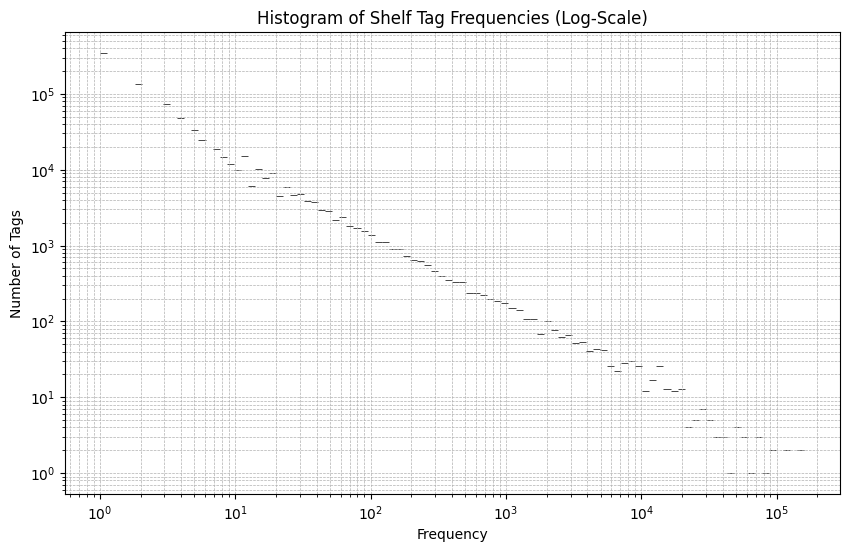

In [ ]:
plt.figure(figsize = (10,6))
sns.histplot(ps_df["count"], bins = 100, log_scale=(True,True))
plt.title("Histogram of Shelf Tag Frequencies (Log-Scale)")
plt.xlabel("Frequency")
plt.ylabel("Number of Tags")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

The histogram shows a steep long-tail distribution of shelf tag frequencies. Most tags occur very infrequently (left side), indicating noise or personal tags, while a small number of tags appear extremely frequently (right side), likely representing generic or behavioral tags such as "to-read" or "favorites".

Cutoff-150
- Because the steep drop in the number of tags begins to flatten. This implies that tags appearing fewer than 100 times are less common and likely less meaningful.
- Tags used at least 150 times are more likely to reflect shared, genre-level categorization rather than one-off or personal usage.


In [ ]:
pruned_df = ps_df[ps_df['count']>150].copy()

In [ ]:
pruned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 0 to 353702
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   genre   8105 non-null   object
 1   count   8105 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 190.0+ KB


Pruning on a frequency threshold of ≥150 reduced the shelf tag vocabulary from 896,799 to 10,105 — a ~99% reduction that retains only the most consistently used tags for downstream genre classification.

###Create Seed List

Implementation strategy:

- Add columns for exact_match, synonym_match, fuzzy_match, final_genre

- Match step-by-step using your seed set and rapidfuzz

- Export leftovers for manual review

- Build final genre_set from accepted matches

In [ ]:
genre_seed = [
    '10th-century', '11th-century', '12th-century', '13th-century', '14th-century',
    '15th-century', '16th-century', '17th-century', '18th-century', '19th-century',
    '1917', '20th-century', '21st-century', 'abuse', 'academic', 'accounting', 'adoption',
    'adolescence', 'adult-fiction', 'adventure', 'african', 'african-american literature',
    'age-gap romance', 'agender', 'agriculture', 'airlines', 'alcohol', 'alchemy',
    'aliens', 'algorithms', 'alternate-universe', 'american', 'american-fiction',
    'american-history', 'american-literature', 'american-civil-war','american revolution',
    'ancient','ancient-history','anime', 'anthropology', 'amish', 'amish-fiction',
    'anti-racist', 'anti-science', 'antisemitism', 'antiwar', 'apocalyptic', 'apotheosis',
    'applied-mathematics', 'archaeology', 'architecture', 'arithmetic', 'art', 'art-of-war',
    'art-and-photography', 'artificial-intelligence', 'asexual', 'astronomy', 'astrology',
    'asia', 'asian-literature', 'atheism', 'australia','autistic-spectrum','autobiography',
    'babylon','back-to-school', 'bad-science','bangladesh', 'banking', 'baseball', 'basketball',
    'banned-books', 'battle-of-britan', 'bdsm', 'beauty-and-the-beast', 'beer','belief', 'belgian',
    'biblical', 'billionaire-romance', 'biography', 'biography-memoir','biology','birds',
    'bisexual romance', 'bisexual','black-literature', 'boys-love', 'bulgaria',
    'business', 'business-economics', 'business-finance', 'business-success','calculus',
    'canada', 'canadian literature', 'cars', 'cartography', 'canon', 'cartoon', 'category-romance',
    'catholic', 'cats', 'central-africa', 'chemistry', 'childrens', 'children-classics',
    'childrens-fiction', 'china', 'chinese literature', 'chivalry', 'christian', 'christian-fiction',
    'christian-lit','christian-living', 'christian-non-fiction', 'christmas', 'church',
    'church-history', 'cinderella', 'cities', 'civil-engineering', 'civil-war',
    'classics', 'classics-fiction', 'classics-non-fiction', 'classic-literature',
    'classical-music', 'classical-studies', 'clean-romance', 'climate-change',
    'climbing', 'cocktails', 'coding', 'collections', 'college', 'college-romance',
    'colouring-books', 'comedian', 'comedy', 'comic', 'comic-fantasy', 'comics-manga',
    'coming-of-age', 'communication', 'computer-science', 'cyberpunk',
    'computers', 'conspiracy-theories', 'construction', 'consumer-economics', 'contemporary',
    'contemporary-romance','cookbooks', 'cooking', 'counselling', 'counter-culture',
    'counting', 'cozy', 'crime', 'criticism', 'crochet', 'cross-dressing', 'cusine',
    'culinary', 'cult-classics', 'cultural', 'cultural-heritage', 'cultural-studies',
    'cyberpunk', 'cycling', 'czech-literature', 'dark', 'dark-academia','dark-fantasy',
    'dark-humor','dark-romance', 'dc-comics', 'death', 'deception', 'demons', 'denmark',
    'dentistry','design', 'detective', 'diary', 'dictionaries', 'diets', 'dinosaurs',
    'disability','discipleship', 'disease', 'distrust', 'divination', 'divorce', 'dog',
    'domestic', 'dragons', 'drama', 'dungeons-and-dragons', 'dutch-literature', 'dystopian',
    'earth', 'earth-science', 'eastern-philosophy', 'ecology', 'economics','economic development',
    'education', 'egypt', 'egyptian-literature', 'edwardian',
    'electrical-engineering', 'elves', 'emergency', 'emotion', 'enemies-to-lovers',
    'engineering', 'english-civil-war', 'english-literature', 'entrepreneurship', 'environment',
    'epic', 'epic-fantasy', 'epic-poetry', 'erotic-romance', 'erotica', 'esoterica',
    'espionage', 'essays', 'ethiopia','ethnic', 'ethnic-studies','ethnicity', 'european-history',
    'evangelism', 'evolution', 'fables', 'fae', 'fairies', 'fairy-tales', 'faith',
    'fake-dating', 'family', 'family-law', 'fandom', 'fantasy', 'fantacy-romance', 'fashion',
    'fat', 'feminism', 'fiction', 'field-guide', 'fighters', 'film', 'finance',
    'financial-management', 'finnish-literature', 'fitness', 'folklore', 'folk-tales',
    'food', 'food-and-drink', 'food-science', 'football', 'forced-proximity',
    'forgotten-realms', 'fostering', 'found-family', 'frankenstein', 'french-literature',
    'friendship', 'futuristic', 'game-design', 'games', 'gardening', 'gay', 'geek','gender',
    'gender-and-sexuality','gender-studies', 'genetics', 'geography',
    'german-literature', 'geology', 'germany', 'ghost-stories',
    'ghosts','global-warming', 'god', 'gothic', 'gothic-horror', 'government',
    'grad-school', 'graphic-novels', 'greek-mythology', 'green', 'grief','growth',
    'guidebook','hackers', 'halloween', 'harem', 'harlequin', 'harlequin-romance',
    'health','herbs', 'heroic-fantasy', 'hinduism', 'high-school', 'hip-hop','historical',
    'historical-fantasy', 'historical-fiction', 'history', 'history-and-politics',
    'hockey', 'holiday', 'holocaust', 'horror', 'horror-thriller', 'horses', 'how-to',
    'human-development', 'human-resources', 'humanity', 'humor', 'hungarian-literature',
    'illness', 'income-tax', 'india', 'indian-literature', 'indonesia', 'informatics',
    'information-science', 'inspirational', 'international', 'international-development',
    'international-literature','internet', 'investigative',
    'ireland', 'irish-literature', 'islam', 'israel', 'italy', 'japan', 'japanese-literature',
    'jazz', 'jewish', 'journalism', 'judaism', 'justice', 'juvenile', 'kenya', 'knitting',
    'language', 'latin-american', 'law', 'leadership', 'legal-thriller', 'lesbian', 'lgbt',
    'librarianship', 'light-novel', 'linguistics', 'literary-criticism', 'literary-fiction',
    'literature', 'logic', 'love', 'love-story', 'low-fantasy', 'm-m', 'mafia', 'magic',
    'management','manga', 'marriage', 'manga-romance', 'manhwa', 'maps', 'martial-arts',
    'marvel', 'mathematics', 'medical', 'menage', 'mental-health', 'mental-illness',
    'mermaids', 'meta-physics', 'microhistory', 'military-fiction', 'military-history',
    'military-romance', 'military-science-fiction', 'modern', 'modern-classics', 'money',
    'monsters', 'mountaineering', 'murder-mystery', 'museums', 'music', 'mystery',
    'mystery-romance', 'mystery-thriller','mysticism', 'mythology', 'native-american',
    'natural-history', 'nature', 'nazi', 'near-future', 'nerd', 'neuroscience','new-adult',
    'new-adult-romance', 'new-age', 'new-york', 'noir', 'non-fiction', 'novella',
    'novels', 'nsfw', 'nutrition', 'occult', 'old-testament', 'omegaverse', 'outdoors',
    'paganism', 'pakistan', 'paranormal', 'parenting', 'personal-development','personal-finance',
    'philosophy','photography', 'physical-therapy', 'physics', 'picture-books',
    'pirates', 'planets', 'plays', 'poland', 'police', 'polyamorous', 'polygamy',
    'pop-culture', 'popular-science', 'portugal','pornography','post-apocalyptic',
    'poverty', 'prayer', 'prehistoric', 'programming', 'pseudoscience', 'prostitution',
    'psychology', 'public-transport', 'pulp', 'puzzles', 'quantum-mechanics', 'queer',
    'race', 'read-for-school','read-for-college','realistic-fiction', 'recreation',
    'regency', 'regency-romance', 'relationships', 'religion','research', 'retellings',
    'road-trips', 'romance', 'romanian', 'romantic', 'romantic-comedy', 'romantic-suspense',
    'royal-romance', 'romantasy', 'russia', 'russian-literature', 'russian-revolution',
    'scandinavian-literature', 'school', 'science','science-fiction', 'science-nature',
    'self-help', 'scotland', 'scripture', 'self-building', 'serial-killer', 'sexuality',
    'shapeshifters', 'short-stories', 'short-stories-collections','slice-of-life',
    'slow-burn', 'small-town-romance', 'social', 'social-issues', 'social-justice',
    'social-media', 'social-movements', 'social-science', 'society', 'sociology',
    'software', 'soldiers', 'south america', 'southern', 'space', 'spain', 'spanish-literature',
    'spanish-civil-war', 'speculative fiction', 'spicy romance', 'spirituality',
    'sports', 'sports-romance', 'storytime', 'summer', 'summer-reads', 'superheroes',
    'supernatural', 'surreal', 'survival' , 'suspense', 'sustainability', 'sweden',
    'swedish-literature', 'taoism', 'sword-and-sorcery', 'teaching', 'technical',
    'technology', 'teen', 'terrorism', 'textbooks', 'theater', 'theology', 'thriller',
    'time-travel', 'tragedy', 'transgender', 'train', 'translated-fiction', 'travel',
    'travelogue', 'true-story','turkish', 'true-crime', 'ukraine', 'united-states',
    'urban-planning', 'utopia', 'vacation-reads','vampires', 'vegan', 'vegetarian',
    'victorian', 'victorian-romance', 'video-games', 'war', 'werewolves', 'western-romance',
    'whodunit', 'wildlife','witchcraft','witches', 'wolves', 'wizards', 'womens',
    'womens-studies', 'wonder-woman', 'world-history', 'workplace-romance', 'world-war-i',
    'world-war-ii', 'writing', 'young-adult', 'young-adult-contemporary', 'young-adult-fantasy',
    'young-adult-romance', 'young-readers', 'zen','zombies'
]

In [ ]:
synonym_map = {
    # Abbreviations
    "sci-fi": "science-fiction",
    "sf": "science-fiction",
    "ya": "young-adult",
    "na": "new-adult",
    "bio": "biography",
    "nonfiction": "non-fiction",
    "memoirs": "biography-memoir",
    "auto-biography": "autobiography",

    # Tropes & themes
    "mm": "m-m",
    "lgbtq": "lgbt",
    "lgbtq+": "lgbt",
    "queer-lit": "queer",
    "wlw": "lesbian",
    "mlm": "m-m",
    "boyslove": "boys-love",
    "bl": "boys-love",
    "ya-contemporary": "young-adult-contemporary",
    "ya-romance": "young-adult-romance",
    "ya-fantasy": "young-adult-fantasy",

    # Common misspellings
    "fantacy": "fantasy",
    "epic-fantacy": "epic-fantasy",
    "romantacy": "romantasy",
    "suspence": "suspense",
    "spirutality": "spirituality",
    "artificail intelligence": "artificial-intelligence",

    # Genre variations
    "graphic-novel": "graphic-novels",
    "graphic novels": "graphic-novels",
    "comic-books": "comics-manga",
    "comics": "comics-manga",
    "manga-comic": "comics-manga",

    # Compound simplifications
    "crime-thriller": "thriller",
    "murder mystery": "murder-mystery",
    "detective fiction": "detective",
    "rom-com": "romantic-comedy",
    "romcom": "romantic-comedy",
    "alt-history": "alternate-universe",
    "alternate-history": "alternate-universe",
    "cli-fi": "climate-change",

    # Age/reading level
    "children": "childrens",
    "kids": "childrens",
    "picture books": "picture-books",
    "chapter books": "childrens-fiction",

    # Spirituality
    "spiritual": "spirituality",
    "religious": "religion",

    # Academic/subject
    "cs": "computer-science",
    "econ": "economics",
    "math": "mathematics",
    "bioinformatics": "informatics",
    "comp-sci": "computer-science"
}


In [ ]:
#normalise the genre to remove trailing spaces or hyphen
import re

def normalise(genre):
  genre = genre.lower().strip()
  genre = re.sub(r"[-_]"," ",genre)
  genre = re.sub(r"\s+", " ", genre)
  return genre

pruned_df["cleaned_genre"] = pruned_df["genre"].apply(normalise)

In [ ]:
#apply same normalization on genre seed list
genre_seed = [normalise(g) for g in genre_seed]

In [ ]:
#apply normalization to synonym map
normalized_synonym_map = {
    normalise(key):normalise(value)
    for key,value in synonym_map.items()
}

In [ ]:
from rapidfuzz import process, fuzz

# Checks if the given tag matches any genre in genre_seed using fuzzy matching.
# Returns True if match score exceeds the threshold, else False.

def fuzzy_match(tag, threshold = 90):
  result = process.extractOne(tag,genre_seed, scorer= fuzz.token_set_ratio)

  # Ensure result is not None before checking score to avoid a TypeError.
  # Returns True only if a match exists and its score exceeds the threshold.
  if result and result[1]>threshold:
    return True
  return False


In [ ]:
# Combines multiple matching strategies to classify a genre.
# Returns True if any of the match types (exact, synonym, or fuzzy) succeeded.

def resolve_final(row):
  return row["exact_match"] or row["synonym_match"] or row["fuzzy_match"]


In [ ]:
# Flag rows as True or False by checking if cleaned_genre matches any
# item in the genre_seed list (case-insensitive)

import numpy as np

pruned_df['exact_match'] = pruned_df["cleaned_genre"].isin(genre_seed)

In [ ]:
#Check if each cleaned_genre has a match in the normalized_synonym_map.
# If a synonym is found, label it as True; otherwise, label it as False.

pruned_df["synonym_match"] = pruned_df["cleaned_genre"].apply(lambda x: bool(normalized_synonym_map.get(x)))

In [ ]:
# Apply fuzzy matching to each cleaned genre and store True/False based on threshold match.

pruned_df["fuzzy_match"] = pruned_df["cleaned_genre"].apply(fuzzy_match)

In [ ]:
# Combine exact, synonym, and fuzzy match results into a final genre classification.

pruned_df["final_genre_classification"] = pruned_df.apply(resolve_final,axis = 1)

In [ ]:
pruned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8105 entries, 0 to 353702
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       8105 non-null   object
 1   count                       8105 non-null   int64 
 2   cleaned_genre               8105 non-null   object
 3   exact_match                 8105 non-null   bool  
 4   synonym_match               8105 non-null   bool  
 5   fuzzy_match                 8105 non-null   bool  
 6   final_genre_classification  8105 non-null   bool  
dtypes: bool(4), int64(1), object(2)
memory usage: 284.9+ KB


In [ ]:
pruned_df["final_genre_classification"].value_counts()

,count
final_genre_classification,
False,5698
True,2407


In [ ]:
len(genre_seed)

594

In [ ]:
remove_list = [
    "to read", "currently reading", "favorites",
    "owned", "books i own", "november 2013","read 2015",
    "z own", "first reads giveaways","kindle","library",
    "ebook","default", "owned books", "ebooks", "my books",
    "to buy", "wishlist", "my library", "read in 2016","read in 2017",
    "i own", "books", "read in 2015", "favourites", "audiobooks", "audio", "maybe", "own it", "read in 2017"]


In [ ]:
pruned_df = pruned_df[~pruned_df["cleaned_genre"].isin(remove_list)]

In [ ]:
sorted_pruned_df = pruned_df.sort_values("count", ascending=False)

In [ ]:
#drop duplicates if any
pruned_df = sorted_pruned_df.drop_duplicates(subset= "cleaned_genre",keep='first')
pruned_df = pruned_df.reset_index(drop=True)

In [ ]:
pruned_df.loc[pruned_df["cleaned_genre"]=="post apocalypse"]

,genre,count,cleaned_genre,exact_match,synonym_match,fuzzy_match,final_genre_classification
2056,post-apocalypse,672,post apocalypse,False,False,False,False


###Embedding Based Clustering on Non-Genre

In [ ]:
to_clusters = pruned_df.loc[pruned_df['final_genre_classification']==False,["cleaned_genre","count"]]

In [ ]:
to_clusters.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5667 entries, 1 to 8058
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   cleaned_genre  5667 non-null   object
 1   count          5667 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 132.8+ KB


In [ ]:
cluster_list = to_clusters["cleaned_genre"].tolist()

###Generate Sentence embeddings

In [ ]:
#Generate Sentence embeddings
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(cluster_list, show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/178 [00:00<?, ?it/s]

###Cluster the embeddings

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(
    min_cluster_size = 10,
    metric = "euclidean",
    cluster_selection_method="eom"
)
labels = clusterer.fit_predict(embeddings)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
to_clusters["cluster"] = labels

In [ ]:
cluster_summary = (
    to_clusters.groupby("cluster")["cleaned_genre"]
    .apply(lambda tags: list(tags.value_counts().head(10).items()))
    .rename("top_terms")
    .reset_index()
)
print(cluster_summary)

   cluster                                          top_terms
0       -1  [(jewish themes, 1), (abandoned, 1), (referenc...
1        0  [(higher education, 1), (series, 1), (wish lis...
2        1  [(03 words sd, 1), (02 words sb, 1), (04 words...


In [ ]:
cluster_label_map = {
    -1:True,
    0:False,
    1:False
}

In [ ]:
to_clusters["cluster_class"] = to_clusters['cluster'].map(cluster_label_map)

###Incorporating cluster decision into pipeline

In [ ]:
pruned_df = pruned_df.merge(
    to_clusters[["cleaned_genre","cluster_class"]],
    on = "cleaned_genre",
    how = "left"
)


In [ ]:
pruned_df.head()

,genre,count,cleaned_genre,exact_match,synonym_match,fuzzy_match,final_genre_classification,cluster_class
0,fiction,123708,fiction,True,False,True,True,NaN
1,series,86375,series,False,False,False,False,False
2,romance,73477,romance,True,False,True,True,NaN
3,wish-list,69598,wish list,False,False,False,False,False
4,non-fiction,62560,non fiction,True,False,True,True,NaN


In [ ]:
pruned_df["cluster_match"] = pruned_df["cluster_class"] == True

In [ ]:
pruned_df["genre_classification_v1"] = pruned_df['final_genre_classification'] | pruned_df["cluster_match"]

In [ ]:
pruned_df["genre_classification_v1"].value_counts()

,count
genre_classification_v1,
True,5689
False,4355


In [ ]:
pruned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       10044 non-null  object
 1   count                       10044 non-null  int64 
 2   cleaned_genre               10044 non-null  object
 3   exact_match                 10044 non-null  bool  
 4   synonym_match               10044 non-null  bool  
 5   fuzzy_match                 10044 non-null  bool  
 6   final_genre_classification  10044 non-null  bool  
 7   cluster_class               7172 non-null   object
 8   cluster_match               10044 non-null  bool  
 9   genre_classivication_v1     10044 non-null  bool  
 10  genre_classification_v1     10044 non-null  bool  
dtypes: bool(7), int64(1), object(3)
memory usage: 382.7+ KB


In [ ]:
pruned_df.drop(columns=["genre_classivication_v1","cluster_class"], inplace = True)

In [ ]:
pruned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       10044 non-null  object
 1   count                       10044 non-null  int64 
 2   cleaned_genre               10044 non-null  object
 3   exact_match                 10044 non-null  bool  
 4   synonym_match               10044 non-null  bool  
 5   fuzzy_match                 10044 non-null  bool  
 6   final_genre_classification  10044 non-null  bool  
 7   cluster_match               10044 non-null  bool  
 8   genre_classification_v1     10044 non-null  bool  
dtypes: bool(6), int64(1), object(2)
memory usage: 294.4+ KB


In [ ]:
#Save the results in genre_classification_v1.parquet file
pruned_df.to_parquet("/content/drive/MyDrive/Book item-item/genre_classification_v1.parquet")

In [ ]:
pruned_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       10044 non-null  object
 1   count                       10044 non-null  int64 
 2   cleaned_genre               10044 non-null  object
 3   exact_match                 10044 non-null  bool  
 4   synonym_match               10044 non-null  bool  
 5   fuzzy_match                 10044 non-null  bool  
 6   final_genre_classification  10044 non-null  bool  
 7   cluster_match               10044 non-null  bool  
 8   genre_classification_v1     10044 non-null  bool  
dtypes: bool(6), int64(1), object(2)
memory usage: 294.4+ KB


In [ ]:
pruned_df["genre_classification_v1"].value_counts()

,count
genre_classification_v1,
True,5689
False,4355


###Filter Popular shelves to only include tags in genre_list

In [ ]:
genre_df = pd.read_parquet("/content/drive/MyDrive/Book item-item/genre_classification_v1.parquet")

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148895 entries, 0 to 162517
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         148895 non-null  string 
 1   authors                      148895 non-null  object 
 2   average_rating               148895 non-null  Float64
 3   ratings_count                148895 non-null  int64  
 4   book_id                      148895 non-null  int64  
 5   popular_shelves              148895 non-null  object 
 6   similar_books                148895 non-null  object 
 7   language_code                148895 non-null  string 
 8   description                  148895 non-null  string 
 9   lemmatized_description_pipe  148895 non-null  object 
 10  normalized_title_key         148895 non-null  object 
dtypes: Float64(1), int64(2), object(5), string(3)
memory usage: 13.8+ MB


In [ ]:
genre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       10044 non-null  object
 1   count                       10044 non-null  int64 
 2   cleaned_genre               10044 non-null  object
 3   exact_match                 10044 non-null  bool  
 4   synonym_match               10044 non-null  bool  
 5   fuzzy_match                 10044 non-null  bool  
 6   final_genre_classification  10044 non-null  bool  
 7   cluster_match               10044 non-null  bool  
 8   genre_classification_v1     10044 non-null  bool  
dtypes: bool(6), int64(1), object(2)
memory usage: 294.4+ KB


In [ ]:
genre_list = genre_df[genre_df["genre_classification_v1"]==True]["genre"].tolist()

In [ ]:
len(genre_list)

5689

In [ ]:
# Assuming genre_list is already lowercased and cleaned
genre_list = set(genre_list)


In [ ]:
popular_shelves = books_df["popular_shelves"].tolist()

In [ ]:
popular_shelves_filtered = [[genre for genre in row if genre in genre_list] for row in popular_shelves]

In [ ]:
books_df["filtered_shelves"] = popular_shelves_filtered

In [ ]:
books_df_filtered =books_df[books_df['filtered_shelves'].map(len)>0]

In [ ]:
books_df.shape

(148895, 12)

In [ ]:
books_df_filtered.shape

(148541, 12)

Around 350 books do not have any tags associated with them

In [ ]:
books_df["filtered_shelves"].loc[1]

['fantasy',
 'young-adult',
 'fiction',
 'harry-potter',
 'ya',
 'magic',
 'childrens',
 'children',
 'adventure',
 'classics',
 'children-s',
 'sci-fi-fantasy',
 'kids',
 'novels',
 'fantasy-sci-fi',
 'paranormal',
 'english',
 'ya-fantasy',
 'childrens-books',
 'urban-fantasy',
 'mystery',
 'teen',
 'supernatural',
 'novel',
 'faves',
 'ya-fiction',
 'juvenile',
 'wizards',
 'scifi-fantasy',
 'young-adult-fiction',
 'children-s-literature',
 'classic',
 'friendship',
 'contemporary',
 'science-fiction-fantasy']

In [ ]:
books_df["popular_shelves"].loc[1]

array(['to-read', 'favorites', 'fantasy', 'young-adult', 'fiction',
       'harry-potter', 'books-i-own', 'owned', 'ya', 'series',
       'favourites', 'magic', 'childrens', 're-read', 'children',
       'adventure', 'owned-books', 'classics', 'children-s', 'childhood',
       'middle-grade', 'reread', 'all-time-favorites', 'j-k-rowling',
       'sci-fi-fantasy', 'children-s-books', 'my-books', 'kids',
       'audiobook', 'favorite-books', 'default', 'audiobooks', 'novels',
       '5-stars', 'i-own', 'favorite', 'read-in-2016', 'fantasy-sci-fi',
       'paranormal', 'read-more-than-once', 're-reads', 'my-library',
       'read-in-2015', 'books', 'english', 'ya-fantasy', 'read-in-2017',
       'childrens-books', 'british', 'urban-fantasy', 'mystery', 'teen',
       'audio', 'favorite-series', 'library', 'supernatural',
       'my-favorites', 'read-in-2014', 'novel', 'faves', 'jk-rowling',
       'own-it', 'ya-fiction', 'harry-potter-series', 'kindle',
       'juvenile', 'childhood-favor

In [ ]:
books_df_filtered.to_parquet("/content/drive/MyDrive/Book_item_item_final/books_df_genres_filtered_v1.parquet")

###Build Recommendation on filtered genre column/filtered shelves

In [ ]:
import pandas as pd

In [ ]:
genre_seed_df = pd.read_parquet("/content/drive/MyDrive/Book item-item/genre_classification_v1.parquet")

In [ ]:
genre_seed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   genre                       10044 non-null  object
 1   count                       10044 non-null  int64 
 2   cleaned_genre               10044 non-null  object
 3   exact_match                 10044 non-null  bool  
 4   synonym_match               10044 non-null  bool  
 5   fuzzy_match                 10044 non-null  bool  
 6   final_genre_classification  10044 non-null  bool  
 7   cluster_match               10044 non-null  bool  
 8   genre_classification_v1     10044 non-null  bool  
dtypes: bool(6), int64(1), object(2)
memory usage: 294.4+ KB


In [ ]:
master_genre_vocab = genre_seed_df.loc[genre_seed_df["genre_classification_v1"]==True, "genre"].tolist()

In [ ]:
len(master_genre_vocab)

5689

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148541 entries, 0 to 162517
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         148541 non-null  string 
 1   authors                      148541 non-null  object 
 2   average_rating               148541 non-null  Float64
 3   ratings_count                148541 non-null  int64  
 4   book_id                      148541 non-null  int64  
 5   popular_shelves              148541 non-null  object 
 6   similar_books                148541 non-null  object 
 7   language_code                148541 non-null  string 
 8   description                  148541 non-null  string 
 9   lemmatized_description_pipe  148541 non-null  object 
 10  normalized_title_key         148541 non-null  object 
 11  filtered_shelves             148541 non-null  object 
dtypes: Float64(1), int64(2), object(6), string(3)
memory usage: 14.

In [ ]:
df_filtered_shelves_list = books_df["filtered_shelves"].tolist()

In [ ]:
type(df_filtered_shelves_list)

list

###Create binary Feature Matrix

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer # Tool to convert multiple labels per item into binary features


#This object will learn the unique genres and transform tag lists.
mlb = MultiLabelBinarizer()

# The fit() part of the operation iterates through every single list of tags in
# filtered_shelves column. It collects all the unique tags it encounters across
# all those lists. For each book, it produces a row in 'genre_matrix_dense'
# where 1 indicates the presence of a genre, 0 indicates its absence.
# the output is numpy array
genre_matrix_dense = mlb.fit_transform(books_df["filtered_shelves"])

# Convert sparse matrix to dense NumPy array for FAISS and ensure float32 dtype:
# FAISS (especially IndexFlatIP) is highly optimized for fast computations on dense,
# contiguous float32 data. float32 ensure numbers are in required 32 bit format for FAISS
genre_matrix_dense = genre_matrix_dense.astype('float32')

# L2-Normalize the vectors for Cosine Similarity: This step ensures that each vector
# has a Euclidean length (L2 norm) of 1.
# This operation is performed "in-place," meaning it modifies 'genre_matrix_dense'
# directly, saving memory and time. hence output is not assigned to another variable
faiss.normalize_L2(genre_matrix_dense)

print(f"Genre Matrix Shape:{genre_matrix_dense.shape}")
print(f"Number of unique genres: {genre_matrix_dense.shape[1]}")



Genre Matrix Shape:(148541, 5689)
Number of unique genres: 5689


In [ ]:
type(genre_matrix_dense)

numpy.ndarray

###FAISS Index for Genre Vectors

In [ ]:
genre_embedding_dimension = genre_matrix_dense.shape[1]

genre_faiss_index = faiss.IndexFlatIP(genre_embedding_dimension)
print("FAISS index built on CPU for genre recommendation")

#add all genre vector to the index
genre_faiss_index.add(genre_matrix_dense)
print(f"Total genre vectors indexed: {genre_faiss_index.ntotal}")



FAISS index built on CPU for genre recommendation
Total genre vectors indexed: 148541


In [ ]:
genre_faiss_index

<faiss.swigfaiss_avx512.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x795aa9072f70> >

###Precompute Neighbors for all books

In [ ]:
import pickle

In [ ]:


book_ids = books_df["book_id"].to_numpy()

k = 50

distance, indices = genre_faiss_index.search(genre_matrix_dense, k+1)

neighbor_table = {}

#build neighbor table

for i, (idx,dist) in enumerate(zip(indices, distance)):
  src_id = int(book_ids[i])
  pairs = [
      (int(book_ids[j]), float(score))
      for j, score in zip(idx[1:], dist[1:])
  ]
  neighbor_table[src_id] = pairs


with open("data/computed_neighbors_popular_shelf_v1.pkl", "wb") as f:
  pickle.dump(neighbor_table, f)

print(f"Built neighbor table for {len(neighbor_table)} books.")




Built neighbor table for 148541 books.


In [ ]:
len(neighbor_table)

148541

##Similar books

In [ ]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 148895 entries, 0 to 162517
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title_without_series         148895 non-null  string 
 1   authors                      148895 non-null  object 
 2   average_rating               148895 non-null  Float64
 3   ratings_count                148895 non-null  int64  
 4   book_id                      148895 non-null  int64  
 5   popular_shelves              148895 non-null  object 
 6   similar_books                148895 non-null  object 
 7   language_code                148895 non-null  string 
 8   description                  148895 non-null  string 
 9   lemmatized_description_pipe  148895 non-null  object 
 10  normalized_title_key         148895 non-null  object 
dtypes: Float64(1), int64(2), object(5), string(3)
memory usage: 13.8+ MB


In [ ]:
sim_books_df = books_df[books_df["similar_books"].map(len)>0][["book_id","similar_books"]]

In [ ]:
sim_books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129445 entries, 0 to 162514
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   book_id        129445 non-null  int64 
 1   similar_books  129445 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.0+ MB


In [ ]:
books_df['similar_books']

,similar_books
0,"[1902241, 146499, 954674, 9917938, 10165727, 7..."
1,"[13830, 127586, 121822, 37586, 6164358, 807968..."
2,"[10051706, 11418182, 10327303, 9627755, 275844..."
3,"[18114322, 251688, 577283, 331319, 10461, 4622..."
4,"[311163, 3008, 1499952, 17567, 2006427, 7898, ..."
...,...
162513,"[17825235, 17610196, 6719550, 256103, 22600, 1..."
162514,"[21197, 1052353, 152705, 132687, 463634, 24602..."
162515,[]
162516,[]


In [ ]:
sim_books_df.shape

(129445, 2)

In [ ]:
neighbor_table_similar_books = {}
for id, sim in zip(sim_books_df["book_id"],sim_books_df["similar_books"]):
  neighbor_table_similar_books[id] = sim.tolist()


In [ ]:
len(neighbor_table_similar_books)

129445

In [ ]:
neighbor_table_similar_books

{2767052: ['1902241',
  '146499',
  '954674',
  '9917938',
  '10165727',
  '7826116',
  '8901953',
  '10025305',
  '153785',
  '199786',
  '13425846',
  '7304203',
  '295650',
  '775977',
  '9424367',
  '10637766',
  '6527740',
  '7849341'],
 3: ['13830',
  '127586',
  '121822',
  '37586',
  '6164358',
  '807968',
  '68458',
  '9783491',
  '444304',
  '7987',
  '12127750',
  '51428',
  '784911',
  '259836',
  '47570',
  '773693',
  '169879'],
 11870085: ['10051706',
  '11418182',
  '10327303',
  '9627755',
  '275844',
  '12384984',
  '9634267',
  '7818683',
  '7540092',
  '17340050',
  '13069681',
  '9275658',
  '8662836',
  '8714383',
  '7507889',
  '2023177',
  '1629601',
  '9165406'],
 5107: ['18114322',
  '251688',
  '577283',
  '331319',
  '10461',
  '46227',
  '4645',
  '46164',
  '390353',
  '30933',
  '58345',
  '7763',
  '1150750',
  '62220',
  '44516',
  '10956',
  '11437',
  '294459'],
 1885: ['311163',
  '3008',
  '1499952',
  '17567',
  '2006427',
  '7898',
  '144463',
  '

In [ ]:
with open("data/neighbors_similar_book_v1.pkl", "wb") as f:
  pickle.dump(neighbor_table_similar_books, f)